# Semantic Code Search using Transformers and BERT - Part I 
Author - Shashank Ramesh

<b>Objective</b> - To summarize we would be building a search engine which would take input a search query, find a function from a large pool of source code which implements the functionality semantically matching what is being queried.

<img src="images/2.png" />

In Part-I of the series where we discuss on gathering the data for training our model and preprocessing the raw data to make it useful for our models to gather insights from.

## Data Collection and Preprocessing
This notebook contains steps to gather the data for training our model and preprocessing the raw data to make it useful for our models to gather insights from.

In [1]:
#importing libraries

import ast
import sqlite3

import glob
import re
from pathlib import Path

import astor
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split

### Collecting Data
The data required for making our semantic search engine is large code bases which are made publicly available by GitHub on this [link](https://storage.googleapis.com/kubeflow-examplescode_search/raw_data/000000000000.csv). 

There are 10 such files which can be downloaded by changing the last digit to its successor in the [link](https://storage.googleapis.com/kubeflow-examplescode_search/raw_data/000000000000.csv). The data set contains code from repositories of diverse domains and can help in building a general purpose search engine.

Once downloaded we get a corpus of data containing 12,41,664 files and we can use the below snippet to read all the files.

In [2]:
%%time
# Read the data into a pandas dataframe, and parse out some meta-data

df = pd.concat([pd.read_csv(f'00000000000{i}.csv') for i in range(10)]) # Read all the 10 files into dataframe

df['nwo'] = df['repo_path'].apply(lambda r: r.split()[0]) # Get the name of repository with the owner name
df['path'] = df['repo_path'].apply(lambda r: r.split()[1]) # Path to the code file in the repository
df.drop(columns=['repo_path'], inplace=True)
df = df[['nwo', 'path', 'content']]

Wall time: 1min 2s


In [3]:
df.head()

,nwo,path,content
0,fnl/libfnl,src/fnl/nlp/dictionary.py,"""""""\n.. py:module:: fnl.text.dictionary\n :s..."
1,KivApple/mcu-info-util,mcu_info_util/linker_script.py,from six import iteritems\n\n\ndef generate(op...
2,Yelp/pyleus,examples/bandwith_monitoring/bandwith_monitori...,"from __future__ import absolute_import, divisi..."
3,jhuapl-boss/boss-manage,bin/bearer_token.py,#!/usr/bin/env python3\n\n# Copyright 2016 The...
4,djfroofy/beatlounge,bl/orchestra/base.py,from itertools import cycle\n\nfrom twisted.py...


In [4]:
# Inspect shape of the raw data
df.shape

(1241664, 3)

### Extracting (Function,Docstring) Pairs 

Our goal is to parse the python files into (function, docstring) pairs. 

For this task we will be using the AST library which just as python compilers converts the source code into an abstract syntax tree for analysis. It identifies all different components in the source code and helps us extract them for processing. 

We are interested in extracting the function definitions along with its corresponding docstring removing other information like comments, decorators and function signatures. After we extract the function definition and its docstring we tokenize each of them to remove punctuation, decorators and convert all the tokens to lower case.

<img src="images/1.png" />

In [5]:
def tokenize_docstring(text):
    """Gets filetered docstring tokens which help describe the function"""
    
    # Remove decorators and other parameter signatures in the docstring
    before_keyword, keyword, after_keyword = text.partition(':')
    before_keyword, keyword, after_keyword = before_keyword.partition('@param')
    before_keyword, keyword, after_keyword = before_keyword.partition('param')
    before_keyword, keyword, after_keyword = before_keyword.partition('@brief')
    
    if(after_keyword):    
        words = RegexpTokenizer(r'[a-zA-Z0-9]+').tokenize(after_keyword)
    else:
        before_keyword, keyword, after_keyword = before_keyword.partition('@')
        words = RegexpTokenizer(r'[a-zA-Z0-9]+').tokenize(before_keyword)
        
    # Convert all docstrings to lowercase
    new_words= [word.lower() for word in words if word.isalnum()]
    
    return new_words


def tokenize_code(text):
    """Gets filetered fucntion tokens"""
    
    # Remove decorators and function signatures till the def token
    keyword = 'def '
    before_keyword, keyword, after_keyword = text.partition(keyword)
    words = RegexpTokenizer(r'[a-zA-Z0-9]+').tokenize(after_keyword)
    
    # Convert function tokens to lowercase and remove single alphabet variables
    new_words= [word.lower() for word in words if (word.isalpha() and len(word)>1) or (word.isnumeric())]
    return new_words


def get_function_docstring_pairs(blob):
    "Extracts (function/method, docstring) pairs from a given code blob."
    
    pairs = []
    try:
        module = ast.parse(blob) # Converts the python code into an abstract syntx tree
        classes = [node for node in module.body if isinstance(node, ast.ClassDef)] # Retrieves classes from source code
        functions = [node for node in module.body if isinstance(node, ast.FunctionDef)] # Retrieves functions from the source code
        for _class in classes:
            functions.extend([node for node in _class.body if isinstance(node, ast.FunctionDef)]) # Retrieves functions from the classes extracted

        for f in functions:
            source = astor.to_source(f) # Convert the functions extracted into ast format so as to remove comments
            docstring = ast.get_docstring(f) if ast.get_docstring(f) else '' # Get docstring from fucntion definition if present
            function = source.replace(ast.get_docstring(f, clean=False), '') if docstring else source # function definition without any comments
            
            # Extracts function name, line number of the function in the source code, original function, function tokens and docstring tokens 
            pairs.append((f.name,         
                          f.lineno,
                          source,
                          ' '.join(tokenize_code(function)),
                          ' '.join(tokenize_docstring(docstring.split('\n\n')[0]))
                         ))
    except (AssertionError, MemoryError, SyntaxError, UnicodeEncodeError):
        pass
    return pairs


def get_function_docstring_pairs_list(blob_list):
    """apply the function `get_function_docstring_pairs` on a list of blobs"""
    return [get_function_docstring_pairs(b) for b in blob_list]

In [6]:
x = df.content.tolist()

In [7]:
func_doc = get_function_docstring_pairs_list(df.content.tolist())

In [8]:
len(func_doc) 

1241664

In [9]:
# The dataset containing a the name of the directory, its path, source code, and all the functions in a list extracted from the source code
df['pairs'] = func_doc
df.head()

,nwo,path,content,pairs
0,fnl/libfnl,src/fnl/nlp/dictionary.py,"""""""\n.. py:module:: fnl.text.dictionary\n :s...","[(__init__, 19, def __init__(self, *leafs, **e..."
1,KivApple/mcu-info-util,mcu_info_util/linker_script.py,from six import iteritems\n\n\ndef generate(op...,"[(generate, 4, def generate(options, filename=..."
2,Yelp/pyleus,examples/bandwith_monitoring/bandwith_monitori...,"from __future__ import absolute_import, divisi...","[(__init__, 18, def __init__(self, size):\n ..."
3,jhuapl-boss/boss-manage,bin/bearer_token.py,#!/usr/bin/env python3\n\n# Copyright 2016 The...,"[(request, 46, def request(url, params=None, h..."
4,djfroofy/beatlounge,bl/orchestra/base.py,from itertools import cycle\n\nfrom twisted.py...,"[(schedule, 149, def schedule(time, func, args..."


### Preparing the dataset
Once we have extracted our function-docstring pairs and their tokens which are free from decorators and other unwanted elements,we stack our findings in a data-frame with every row containing details about a function and its corresponding docstring.

In [10]:
%%time
# flatten pairs
df = df.set_index(['nwo', 'path'])['pairs'].apply(pd.Series).stack()
df = df.reset_index()
df.columns = ['nwo', 'path', '_', 'pair']

Wall time: 6min 30s


In [11]:
df.head()

,nwo,path,_,pair
0,fnl/libfnl,src/fnl/nlp/dictionary.py,0,"(__init__, 19, def __init__(self, *leafs, **ed..."
1,fnl/libfnl,src/fnl/nlp/dictionary.py,1,"(__eq__, 23, def __eq__(self, other):\n if ..."
2,fnl/libfnl,src/fnl/nlp/dictionary.py,2,"(__repr__, 29, def __repr__(self):\n return..."
3,fnl/libfnl,src/fnl/nlp/dictionary.py,3,"(createOrGet, 32, def createOrGet(self, token)..."
4,fnl/libfnl,src/fnl/nlp/dictionary.py,4,"(setLeaf, 47, def setLeaf(self, key, order):\n..."


In [12]:
%%time
# gathering all detailes about the function and its corresponding docstring
df['function_name'] = df['pair'].apply(lambda p: p[0])
df['lineno'] = df['pair'].apply(lambda p: p[1])
df['original_function'] = df['pair'].apply(lambda p: p[2])
df['function_tokens'] = df['pair'].apply(lambda p: p[3])
df['docstring_tokens'] = df['pair'].apply(lambda p: p[4])
df = df[['nwo', 'path', 'function_name', 'lineno', 'original_function', 'function_tokens', 'docstring_tokens']]
df['url'] = df[['nwo', 'path', 'lineno']].apply(lambda x: 'https://github.com/{}/blob/master/{}#L{}'.format(x[0], x[1], x[2]), axis=1)

Wall time: 5min 58s


In [13]:
df.head()

,nwo,path,function_name,lineno,original_function,function_tokens,docstring_tokens,url
0,fnl/libfnl,src/fnl/nlp/dictionary.py,__init__,19,"def __init__(self, *leafs, **edges):\n self...",init self leafs edges self edges edges self le...,,https://github.com/fnl/libfnl/blob/master/src/...
1,fnl/libfnl,src/fnl/nlp/dictionary.py,__eq__,23,"def __eq__(self, other):\n if isinstance(ot...",eq self other if isinstance other node return ...,,https://github.com/fnl/libfnl/blob/master/src/...
2,fnl/libfnl,src/fnl/nlp/dictionary.py,__repr__,29,def __repr__(self):\n return 'Node<leafs={}...,repr self return node leafs edges format self ...,,https://github.com/fnl/libfnl/blob/master/src/...
3,fnl/libfnl,src/fnl/nlp/dictionary.py,createOrGet,32,"def createOrGet(self, token):\n """"""\n\t\tCr...",createorget self token if token in self edges ...,create or get the node pointed to by token fro...,https://github.com/fnl/libfnl/blob/master/src/...
4,fnl/libfnl,src/fnl/nlp/dictionary.py,setLeaf,47,"def setLeaf(self, key, order):\n """"""\n\t\tS...",setleaf self key order self leafs append order...,store the key as a leaf of this node at positi...,https://github.com/fnl/libfnl/blob/master/src/...


### Removing Duplicates
All entries which were duplicates with respect to function definitions or function tokens were removed

In [14]:
%%time
# remove observations where the same function definition appears more than once
before_dedup = len(df)
df = df.drop_duplicates(['original_function'])
after_dedup = len(df)

print(f'Removed {before_dedup - after_dedup:,} duplicate rows')

Removed 1,199,426 duplicate rows
Wall time: 21.7 s


In [15]:
%%time
# remove observations which have the same function tokens appears more than once
before_dedup = len(df)
df = df.drop_duplicates(['function_tokens'])
after_dedup = len(df)

print(f'Removed {before_dedup - after_dedup:,} duplicate rows')

Removed 155,244 duplicate rows
Wall time: 16.8 s


In [16]:
df.shape

(5258685, 8)

### Separate function without docstrings


In [17]:
def listlen(x):
    if not isinstance(x, list):
        return 0
    return len(x)

# separate functions without docstrings
# docstrings should be at least 3 words in the docstring to be considered a valid docstring

with_docstrings = df[df.docstring_tokens.str.split().apply(listlen) >= 3]
without_docstrings = df[df.docstring_tokens.str.split().apply(listlen) < 3]
print('Number of Funtion Snippets with docstring',len(with_docstrings))
print('Number of Funtion Snippets without docstring',len(without_docstrings))

Number of Funtion Snippets with docstring 1244929
Number of Funtion Snippets without docstring 4013756


In [18]:
# Save the dataset of functions with docstrings
with_docstrings.to_csv('processed_full.csv')

In [19]:
# Using SQLlite to analyse the dataset
conn = sqlite3.connect('with_docstrings.sqlite')
c=conn.cursor()
conn.text_factory = str
with_docstrings.to_sql('Data', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [20]:
with_docstrings.head()

,nwo,path,function_name,lineno,original_function,function_tokens,docstring_tokens,url
3,fnl/libfnl,src/fnl/nlp/dictionary.py,createOrGet,32,"def createOrGet(self, token):\n """"""\n\t\tCr...",createorget self token if token in self edges ...,create or get the node pointed to by token fro...,https://github.com/fnl/libfnl/blob/master/src/...
4,fnl/libfnl,src/fnl/nlp/dictionary.py,setLeaf,47,"def setLeaf(self, key, order):\n """"""\n\t\tS...",setleaf self key order self leafs append order...,store the key as a leaf of this node at positi...,https://github.com/fnl/libfnl/blob/master/src/...
5,fnl/libfnl,src/fnl/nlp/dictionary.py,key,62,"@property\ndef key(self):\n """"""Return the m...",key self return self leafs 0 1 if self leafs e...,return the main key of this leaf,https://github.com/fnl/libfnl/blob/master/src/...
6,fnl/libfnl,src/fnl/nlp/dictionary.py,merge,79,"@staticmethod\ndef merge(node1, node2) ->Node:...",merge node if return node leafs edges edges ed...,merge two nodes to produce a new united node w...,https://github.com/fnl/libfnl/blob/master/src/...
7,fnl/libfnl,src/fnl/nlp/dictionary.py,__init__,101,"def __init__(self, data: iter, tokenizer: Toke...",init self data iter tokenizer tokenizer self r...,initialize a new dictionary using a data itera...,https://github.com/fnl/libfnl/blob/master/src/...


In [21]:
# Number of unique repositories
print("Number of repositories -",len(list(set(with_docstrings['nwo']))))

Number of repositories - 37750


In [22]:
# Getting the count of function tokens per function
with_docstrings['function_tokens_count'] = [len(item.split()) for item in list(with_docstrings['function_tokens'].values)]

In [23]:
len(with_docstrings['function_tokens_count'] .values)

1244929

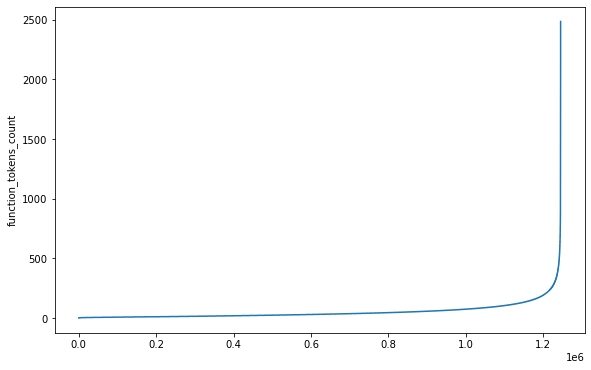

In [24]:
import matplotlib.pyplot as plt
# Plotting the graph of sorted list of function tokens
plt.plot(sorted(list(with_docstrings['function_tokens_count'] .values)))
plt.ylabel('function_tokens_count')
plt.rcParams['figure.figsize'] = [9.5, 6]
plt.show()

In [26]:
# Analysing what must be the minimum count of function tokens by seeing the values returned in sql queries
final = pd.read_sql_query("""
SELECT *
FROM Data
WHERE function_tokens_count>4
ORDER BY function_tokens_count
""", conn)
final[:20]

,index,nwo,path,function_name,lineno,original_function,function_tokens,docstring_tokens,url,function_tokens_count
0,29,djfroofy/beatlounge,bl/orchestra/base.py,pause,45,"def pause(self):\n """"""\n Immediately...",pause self self paused true,immediately pause playing our schedule general...,https://github.com/djfroofy/beatlounge/blob/ma...,5
1,252,Robpol86/Flask-Large-Application-Example,tests/conftest.py,create_all,19,"@pytest.fixture(autouse=True, scope='session')...",create all db create all,create all database tables,https://github.com/Robpol86/Flask-Large-Applic...,5
2,499,paulross/cpip,src/cpip/util/DictTree.py,colSpan,302,"@property\ndef colSpan(self):\n """"""The colu...",colspan self return self colspan,the column span,https://github.com/paulross/cpip/blob/master/s...,5
3,500,paulross/cpip,src/cpip/util/DictTree.py,rowSpan,310,"@property\ndef rowSpan(self):\n """"""The row ...",rowspan self return self rowspan,the row span,https://github.com/paulross/cpip/blob/master/s...,5
4,589,fpiot/mbed-ats,workspace_tools/host_tests/host_tests_plugins/...,load_plugin,63,"def load_plugin():\n """""" Returns plugin ava...",load plugin return hosttestpluginresetmethod s...,returns plugin available in this module,https://github.com/fpiot/mbed-ats/blob/master/...,5
5,840,mice-software/maus,src/reduce/ReducePyKLPlot/test_ReducePyKLPlot.py,setUpClass,32,"@classmethod\ndef setUpClass(self):\n """""" \...",setupclass self self reducer reducepyklplot,prepare for test by setting up worker,https://github.com/mice-software/maus/blob/mas...,5
6,957,netzob/netzob,netzob/src/netzob/Model/Vocabulary/Domain/Vari...,memory,155,"@property\ndef memory(self):\n """"""The conte...",memory self return self memory,the content of the memory is stored in this dict,https://github.com/netzob/netzob/blob/master/n...,5
7,1132,openstack/cinder,cinder/interface/volume_consistencygroup_drive...,create_consistencygroup,27,"def create_consistencygroup(self, context, gro...",create consistencygroup self context group,creates a consistencygroup,https://github.com/openstack/cinder/blob/maste...,5
8,1337,timothycrosley/thedom,thedom/resources.py,scripts,132,"def scripts(self):\n """"""\n Retur...",scripts self return self scripts,returns a list of all passed in scripts,https://github.com/timothycrosley/thedom/blob/...,5
9,1896,wikimedia/pywikibot-core,tests/interwikidata_tests.py,create_item,27,"def create_item(self):\n """"""Prevent creatin...",create item self return false,prevent creating items,https://github.com/wikimedia/pywikibot-core/bl...,5


In [27]:
final.shape

(1227268, 10)

In [28]:
conn = sqlite3.connect('with_docstrings.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Modified', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [29]:
# checking if functions which are overridden are of importance to us
check = pd.read_sql_query("""
SELECT *
FROM Modified
WHERE function_name LIKE '!_!_%' ESCAPE'!'
ORDER BY function_tokens_count
""", conn)
check.head()

,level_0,index,nwo,path,function_name,lineno,original_function,function_tokens,docstring_tokens,url,function_tokens_count
0,21,3995,xiaozhuchacha/OpenBottle,grammar_induction/earley_parser/nltk/stem/lanc...,__init__,169,"def __init__(self):\n """"""Create an instance...",init self self rule dictionary,create an instance of the lancaster stemmer,https://github.com/xiaozhuchacha/OpenBottle/bl...,5
1,31,4886,wummel/linkchecker,linkcheck/htmlutil/formsearch.py,__repr__,35,"def __repr__(self):\n """"""Return unicode rep...",repr self return unicode self,return unicode representation displaying url a...,https://github.com/wummel/linkchecker/blob/mas...,5
2,91,19110,proxysh/Safejumper-for-Desktop,buildlinux/env64/lib/python2.7/site-packages/o...,__init__,28,"def __init__(self):\n """"""\n Initiali...",init self self table dict,initialise a tracker object,https://github.com/proxysh/Safejumper-for-Desk...,5
3,112,22482,ganga-devs/ganga,ganga/GangaCore/GPIDev/Adapters/ICredentialReq...,__str__,41,"def __str__(self):\n """""" Returns the repr a...",str self return repr self,returns the repr as defined within repr,https://github.com/ganga-devs/ganga/blob/maste...,5
4,115,22851,twilio/twilio-python,twilio/rest/pricing/v1/__init__.py,__repr__,57,"def __repr__(self):\n """"""\n Provide ...",repr self return twilio pricing,provide a friendly representation,https://github.com/twilio/twilio-python/blob/m...,5


In [30]:
final.to_csv('processed_full2.csv')

## Train-Validation-Test Split
It was decided not to randomly split the data set instead to group the entries according to the repositories they belong and then split the data set. 

In [31]:
#Grouping entries by thie repository name
grouped = final.groupby('nwo')

In [32]:
# train, valid, test splits
train, valid = train_test_split(list(grouped), train_size=0.9, random_state=8081)
train, test = train_test_split(train, train_size=0.9, random_state=8081)

In [33]:
train = pd.concat([d for _, d in train]).reset_index(drop=True)
valid = pd.concat([d for _, d in valid]).reset_index(drop=True)
test = pd.concat([d for _, d in test]).reset_index(drop=True)

In [34]:
print(f'train set num rows {train.shape[0]:,}')
print(f'valid set num rows {valid.shape[0]:,}')
print(f'test set num rows {test.shape[0]:,}')
print(f'without docstring rows {without_docstrings.shape[0]:,}')

train set num rows 996,341
valid set num rows 125,377
test set num rows 105,550
without docstring rows 4,013,756


Preview what the training set looks like.  You can start to see how the data looks, the function tokens and docstring tokens are what will be fed downstream into the models.  The other information is important for diagnostics and bookeeping.

In [35]:
train.head()

,index,nwo,path,function_name,lineno,original_function,function_tokens,docstring_tokens,url,function_tokens_count
0,261729,y12studio/y12docker,pbnet/cron/py/cron.py,__init__,17,"def __init__(self, reschedule_on_failure=True)...",init self reschedule on failure true self resc...,if reschedule on failure is true jobs will be ...,https://github.com/y12studio/y12docker/blob/ma...,16
1,6257679,yhat/pandasql,pandasql/sqldf.py,sqldf,129,"def sqldf(query, env=None, db_uri='sqlite:///:...",sqldf query env none db uri sqlite memory retu...,query pandas data frames using sql syntax this...,https://github.com/yhat/pandasql/blob/master/p...,14
2,6257677,yhat/pandasql,pandasql/sqldf.py,extract_table_names,110,"def extract_table_names(query):\n """""" Extra...",extract table names query tables blocks re fin...,extract table names from an sql query,https://github.com/yhat/pandasql/blob/master/p...,29
3,6257676,yhat/pandasql,pandasql/sqldf.py,get_outer_frame_variables,98,"def get_outer_frame_variables():\n """""" Get ...",get outer frame variables cur filename inspect...,get a dict of local and global variables of th...,https://github.com/yhat/pandasql/blob/master/p...,39
4,6257678,yhat/pandasql,pandasql/sqldf.py,write_table,120,"def write_table(df, tablename, conn):\n """"""...",write table df tablename conn with catch warni...,write a dataframe to the database,https://github.com/yhat/pandasql/blob/master/p...,44


## Sorting the datasets
This was done for addition of minimal padding tokens while training

In [36]:
train_df.sort_values(by=['function_tokens_count'], inplace=True)
valid_df.sort_values(by=['function_tokens_count'], inplace=True)
test_df.sort_values(by=['function_tokens_count'], inplace=True)

In [37]:
train_df.to_csv('train_sorted.csv')
valid_df.to_csv('valid_sorted.csv')
test_df.to_csv('test_sorted.csv')